## Pure Premium Modeling via a Product Model vs single TweedieRegressor

通过乘积模型与单个 TweedieRegressor 进行纯保费建模

As mentioned in the introduction, the total claim amount per unit of exposure can be modeled as the product of the prediction of the frequency model by the prediction of the severity model.

正如导言中提到的，每个风险敞口内的索赔总额可以建模为严重性模型预测频率模型预测的乘积。

Alternatively, one can directly model the total loss with a unique Compound Poisson Gamma generalized linear model(with a log link function). 

或者，可以使用唯一的复合泊松伽马广义线性模型（具有对数链接函数）直接对总损失进行建模。

This model is a special case of the Tweedie GLM with a `power` parameter p ∈ (1, 2). 

该模型是 Tweedie GLM 的一个特例，具有 “幂” 参数 pθ（1,2）。

Here, we fix apriori the `power` parameter of the Tweedie model to some arbitrary value(1.9) in the valid range.

在这里，我们将 Tweedie 模型的幂参数先验固定为有效范围内的任意值（1.9）。

Ideally one would select this value via grid-search by minimizing the negative log-likelihood of the Tweedie model, but unfortunately the current implementation does not allow for this (yet).

理想情况下，可以通过网格搜索通过最小化 Tweedie 模型的负对数似然来选择这个值，但不幸的是，当前的实现（还）不允许这样做。

We will compare the performance of both approaches. To quantify the performance of both models, one can compute the mean deviance of the train and test data assuming a Compound Poisson-Gamma distribution of the total claim amount. 

我们将比较两种方法的性能。为了量化两种模型的性能，可以计算训练的平均偏差，并假设总索赔额的复合泊松 - 伽马分布测试数据。

This is equivalent to a Tweedie distribution with a `power` parameter between 1 and 2.

这相当于一个 Tweedie 分布，其 “power” 参数介于 1 和 2 之间。


The `sklearn.metrics.mean_tweedie_deviance` depends on a power parameter. As we do not know the true value of the `power` parameter, we here compute the mean deviances for a grid of possible values, and compare the models side by side, i.e. we compare them at identical values of `power`. 

mean_tweedie_deviance 依赖于功率参数。由于我们不知道功率参数的真实值，我们在这里计算可能值的网格的平均偏差，并并排比较模型，即我们在相同的功率值下比较它们。

Ideally, we hope that one model will be consistently better than the other, regardless of `power`.
理想情况下，我们希望一个模型始终比另一个更好，不管 “幂值” 如何。


#####################################################################
## 特征处理
#####################################################################

In [1]:
import pandas as pd

df = pd.read_csv('data/insurance_claims_label_feature.csv')

print('df shape: {}'.format(df.shape))
df.head()

df shape: (678013, 91)


,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,...,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74
0,0.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,50.0,0.600055
1,0.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,50.0,0.600055
2,0.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50.0,-1.065404
3,0.0,0.09,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50.0,-0.882694
4,0.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50.0,-0.882694


In [2]:
columns_x = ['X{}'.format(idx) for idx in range(75)]
df_x = df[columns_x]

print('df_x shape: {}'.format(df_x.shape))
df_x.head()

df_x shape: (678013, 75)


,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,50.0,0.600055
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,50.0,0.600055
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50.0,-1.065404
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50.0,-0.882694
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,50.0,-0.882694


In [3]:
columns_y = ['ClaimNb','Exposure','Area','VehPower','VehAge','DrivAge',
             'BonusMalus','VehBrand','VehGas','Density','Region',
             'ClaimAmount','PurePremium','Frequency','AvgClaimAmount']
df_y = df[columns_y]

print('df_y shape: {}'.format(df_y.shape))
df_y.head()

df_y shape: (678013, 15)


,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency,AvgClaimAmount
0,0.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0,0.0,0.0,0.0
1,0.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0,0.0,0.0,0.0
2,0.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22,0.0,0.0,0.0,0.0
3,0.0,0.09,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0,0.0,0.0,0.0
4,0.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0,0.0,0.0,0.0


In [4]:
len(df[df['ClaimAmount'] > 0])

24944

In [5]:
from sklearn.model_selection import train_test_split

y_train, y_test, x_train, x_test = train_test_split(df_y, df_x, random_state=0)

print('y_train shape: {}, \t y_test shape: {}, \n x_train shape: {}, \t x_test shape: {}'
      .format(y_train.shape, y_test.shape, x_train.shape, x_test.shape))

y_train shape: (508509, 15), 	 y_test shape: (169504, 15), 
 x_train shape: (508509, 75), 	 x_test shape: (169504, 75)


#####################################################################
## 模型构建
#####################################################################

In [6]:
import pandas as pd
from functools import partial
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_tweedie_deviance,
)

def score_estimator(
        estimator,
        x_train,
        x_test,
        y_train,
        y_test,
        target,
        weights,
        tweedie_powers=None,
):
    """Evaluate an estimator on train and test sets with different metrics"""

    metrics = [
        ('D² explained', None),  # Use default scorer if it exists
        ('mean abs. error', mean_absolute_error),
        ('mean squared error', mean_squared_error),
    ]
    if tweedie_powers:
        metrics += [
            (
                'mean Tweedie dev p={:.4f}'.format(power),
                partial(mean_tweedie_deviance, power=power),
            )
            for power in tweedie_powers
        ]
    res = []
    for subset_label, x_df, y_df in [
        ('train', x_train, y_train),
        ('test', x_test, y_test),
    ]:
        y, _weights = y_df[target], y_df[weights]
        for score_label, metric in metrics:
            if isinstance(estimator, tuple) and len(estimator) == 2:
                # Score the model consisting of the product of frequency and
                # severity models.
                est_freq, est_sev = estimator
                y_pred = est_freq.predict(x_df) * est_sev.predict(x_df)
            else:
                y_pred = estimator.predict(x_df)

            if metric is None:
                if not hasattr(estimator, 'score'):
                    continue
                print('x_df shape: {}, y_df shape: {}'.format(x_df.shape, y_df.shape))
                score = estimator.score(x_df, y, sample_weight=_weights)
            else:
                score = metric(y, y_pred, sample_weight=_weights)
            
            res.append({'subset': subset_label, 'metric': score_label, 'score': score})

    res = (
        pd.DataFrame(res)
        .set_index(['metric', 'subset'])
        .score.unstack(-1)
        .round(4)
        .loc[:, ['train', 'test']]
    )

    return res

In [7]:
from sklearn.linear_model import PoissonRegressor

glm_freq = PoissonRegressor(alpha=1e-4, solver='newton-cholesky')
glm_freq.fit(
    x_train,
    y_train['Frequency'], 
    sample_weight=y_train['Exposure'])

PoissonRegressor(alpha=0.0001, solver='newton-cholesky')

In [8]:
from sklearn.linear_model import GammaRegressor

mask_train = y_train["ClaimAmount"] > 0
mask_test = y_test["ClaimAmount"] > 0

glm_sev = GammaRegressor(alpha=10.0, solver="newton-cholesky")

glm_sev.fit(
    x_train[mask_train.values],
    y_train.loc[mask_train, "AvgClaimAmount"],
    sample_weight=y_train.loc[mask_train, "ClaimNb"],
)

GammaRegressor(alpha=10.0, solver='newton-cholesky')

In [14]:
from sklearn.linear_model import TweedieRegressor

glm_pure_premium = TweedieRegressor(power=1.9, alpha=0.1, solver='newton-cholesky')
glm_pure_premium.fit(X=x_train, y=y_train['PurePremium'], sample_weight=y_train['Exposure'])

tweedie_powers = [1.5, 1.7, 1.8, 1.9, 1.99, 1.999, 1.9999]

scores_product_model = score_estimator(
    (glm_freq, glm_sev),
    x_train=x_train,
    x_test=x_test,
    y_train=y_train,
    y_test=y_test,
    target='PurePremium',
    weights='Exposure',
    tweedie_powers=tweedie_powers,
)

scores_glm_pure_premium = score_estimator(
    glm_pure_premium,
    x_train=x_train,
    x_test=x_test,
    y_train=y_train,
    y_test=y_test,
    target='PurePremium',
    weights='Exposure',
    tweedie_powers=tweedie_powers,
)

scores = pd.concat(
    [scores_product_model, scores_glm_pure_premium],
    axis=1,
    sort=True,
    keys=('Product Model', 'TweedieRegressor'),
)
print('Evaluation of the Product Model and the Tweedie Regressor on target PurePremium')
with pd.option_context('display.expand_frame_repr', False):
    print(scores)

x_df shape: (508509, 75), y_df shape: (508509, 15)
x_df shape: (169504, 75), y_df shape: (169504, 15)
Evaluation of the Product Model and the Tweedie Regressor on target PurePremium
                          Product Model               TweedieRegressor              
subset                            train          test            train          test
metric                                                                              
D² explained                        NaN           NaN     1.640000e-02  1.370000e-02
mean Tweedie dev p=1.5000  7.669930e+01  7.617050e+01     7.640770e+01  7.640880e+01
mean Tweedie dev p=1.7000  3.695740e+01  3.683980e+01     3.682880e+01  3.692270e+01
mean Tweedie dev p=1.8000  3.046010e+01  3.040530e+01     3.037600e+01  3.045390e+01
mean Tweedie dev p=1.9000  3.387580e+01  3.385000e+01     3.382120e+01  3.387830e+01
mean Tweedie dev p=1.9900  2.015716e+02  2.015414e+02     2.015347e+02  2.015587e+02
mean Tweedie dev p=1.9990  1.914573e+03  1.914370e+03

In this example, both modeling approaches yield comparable performance metrics. For implementation reasons, the percentage of explained variance D^2 is not available for
 the product model.

在此示例中，两种建模方法都产生了可比的性能指标。出于实施原因，解释方差 D^2 的百分比不适用于产品模型。

We can additionally validate these models by comparing observed and predicted total claim amount over the test and train subsets. 

我们还可以通过比较测试和训练子集上观察到的和预测的总索赔量来验证这些模型。

We see that, on average, both model tend to understimate the total claim (but this behavior depends on the amount of regularization).

我们看到，平均而言，这两个模型都倾向于低估总索赔（但这种行为取决于正则化的数量）。

In [17]:
import numpy as np

res = []
for subset_label, X, df in [
    ('train', x_train, y_train),
    ('test', x_test, y_test),
]:
    exposure = df['Exposure'].values
    res.append(
        {
            'subset': subset_label,
            'observed': df['ClaimAmount'].values.sum(),
            'predicted, frequency*severity model': np.sum(
                exposure * glm_freq.predict(X=X) * glm_sev.predict(X=X)
            ),
            'predicted, tweedie, power=%.2f' % glm_pure_premium.power: np.sum(exposure * glm_pure_premium.predict(X=X)),
        }
    )
print(pd.DataFrame(res).set_index('subset').T)

subset                                      train          test
observed                             3.917618e+07  1.299546e+07
predicted, frequency*severity model  3.916555e+07  1.313276e+07
predicted, tweedie, power=1.90       3.951751e+07  1.325198e+07


Finally, we can compre the two models using a plot of cumulated claims: for each model, the policyholders are ranked from safest to riskiest based on the model predictions and the fraction of observed total cumulated claims is plotted on the y axis. 

最后，我们可以使用累积索赔图来压缩这两个模型：对于每个模型，根据模型预测，保单持有人从最安全到最有风险进行排名，观察到的累积索赔总额的比例绘制在 y 轴上。

This plot is often called the ordered Lorenz curve of the model.

该图通常称为模型的有序洛伦兹曲线。

The Gini coefficient (based on the area between the curve and the diagonal) can be used as a model selection metric to quantify the ability of the model to rank policyholders. 

基尼系数（基于曲线和对角线之间的面积）可以用作模型选择指标，以量化模型对投保人进行排名的能力。

Note that this metric does not reflect the ability of the models to make accurate predictions in terms of absolute value of total claim amounts but only in terms of relative amounts as a ranking metric. 

请注意，这一指标并不反映模型在总索赔额绝对值方面做出准确预测的能力，而仅反映作为排名指标的相对金额。

The Gini coefficient is upper bounded by 1.0 but even an oracle model that ranks the policyholders by the observed claim amounts cannot reach a score of 1.0

基尼系数的上界为 1.0，但即使是根据观察到的索赔金额对投保人进行排名的预言机模型也无法达到 1.0 的分数

We observe that both models are able to ranke policyholders by risky-ness significantly better than chance although thay are also both far from the oracle model due to the natural difficalty of the prediction problem from a few features: most accidents are not predictable and can be caused by environmental circumstances that are not described at all by the input features of the models.

我们观察到，这两种模型都能够排名投保人的风险明显优于机会，尽管他们也远离甲骨文模型，因为预测问题的自然困难性来自几个特征：大多数事故是不可预测的，可能是由模型的输入特征根本无法描述的环境环境引起的。

Note that the Gini index only characterizes the ranking performance of the model but not its calibration: any monotonic transformation of the predictions leaves the Gini index of the model unchanged.

请注意，基尼系数仅表征模型的排名性能，而不是其校准：预测的任何单调变换都会使模型的基尼系数保持不变。

Finally one should highlight that the Compound Poisson Gamma model that is directly fit on the pure premium is operationally simpler to develop and maintain as it consists of a single scikit-learn estimator instead of a pair of models, each with its own set of hyperparameters.

最后，应该强调的是，直接适合纯溢价的复合泊松伽马模型在操作上更容易开发和维护，因为它由一个单一的 Scikit-Learning 估计器而不是一对模型组成，每个模型都有自己的超参数集。

[]

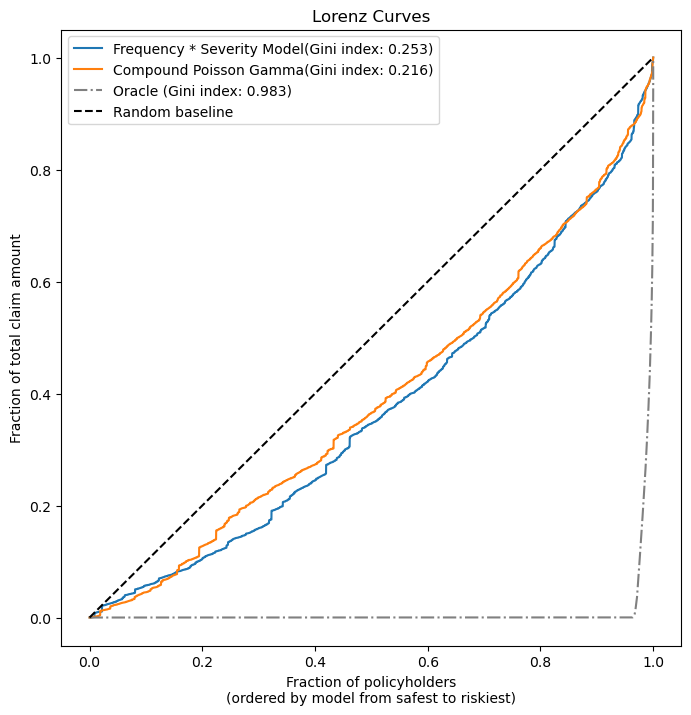

In [20]:
from sklearn.metrics import auc
import matplotlib.pyplot as plt

def lorenz_curve(y_true, y_pred, exposure):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    exposure = np.asarray(exposure)

    # order samples by increasing predicted risk:
    ranking = np.argsort(y_pred)
    ranked_exposure = exposure[ranking]
    ranked_pure_premium = y_true[ranking]
    cumulated_claim_amount = np.cumsum(ranked_pure_premium * ranked_exposure)
    cumulated_claim_amount /= cumulated_claim_amount[-1]
    cumulated_samples = np.linspace(0, 1, len(cumulated_claim_amount))
    return cumulated_samples, cumulated_claim_amount
fig, ax = plt.subplots(figsize=(8, 8))

y_pred_product = glm_freq.predict(x_test) * glm_sev.predict(x_test)
y_pred_total = glm_pure_premium.predict(x_test)

for label, y_pred in [
    ('Frequency * Severity Model', y_pred_product),
    ('Compound Poisson Gamma', y_pred_total),
]:
    ordered_samples, cum_claims = lorenz_curve(
        y_test['PurePremium'], y_pred, y_test['Exposure']
    )
    gini = 1 - 2 * auc(ordered_samples, cum_claims)
    label += '(Gini index: {:.3f})'.format(gini)
    ax.plot(ordered_samples, cum_claims, linestyle='-', label=label)

# Oracle mdoel: y_pred == y_test
ordered_samples, cum_claims = lorenz_curve(
    y_test['PurePremium'], y_test['PurePremium'], y_test['Exposure']
)
gini = 1 - 2 * auc(ordered_samples, cum_claims)
label = 'Oracle (Gini index: {:.3f})'.format(gini)
ax.plot(ordered_samples, cum_claims, linestyle='-.', color='gray', label=label)

# Random baseline
ax.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random baseline')
ax.set(
    title='Lorenz Curves',
    xlabel='Fraction of policyholders\n(ordered by model from safest to riskiest)',
    ylabel='Fraction of total claim amount',
)
ax.legend(loc='upper left')
plt.plot()